## Audio -> Spectrogram -> CNN 

#### Classification
##### Classify each individual -> is individual x / is not individual x

Resources: 
- https://www.tensorflow.org/tutorials/audio/simple_audio
- https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab
- https://www.kaggle.com/code/christianlillelund/classify-mnist-audio-using-spectrograms-keras-cnn
- https://towardsdatascience.com/custom-audio-classification-with-tensorflow-af8c16c38689https://towardsdatascience.com/custom-audio-classification-with-tensorflow-af8c16c38689
- https://www.kaggle.com/code/naveensgowda/adding-echo-in-audio-and-removing-echo-in-an-audio

Data
- Nan's data contains stereo audio data - the left and right channels of the audio are interweaved together in a single file = 2 channels

In [70]:
#Import libraries
import os
import pathlib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from IPython import display

import tensorflow as tf
import tensorflow_io as tfio #collection of file systems/file formats that aren't available in TensorFlow's built-in support.

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

import librosa
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import itertools

#### Load/Extract Data

In [71]:
#setup data directory path 
dataset_path = 'Humpback Songs - different lengths/Humpback Songs - Full Length Checked'
data_dir = pathlib.Path(dataset_path)

In [72]:
labels = np.array(tf.io.gfile.listdir(str(data_dir)))
labels = labels[(labels != '.ipynb_checkpoints') & (labels != '.DS_Store')]
print('Labels:', labels)

Labels: ['Bermuda' 'CookIslands' 'Hawaii' 'MontereyBay']


In [73]:
#creates a dictionary label_counts to store the count of files per class. 
#Then, it loops over the label names and uses os.listdir to count the number of files in each class directory. 
#Finally, it loops over the label counts and prints them out in a readable format.

label_counts = {}
for label in labels:
    label_dir = os.path.join(data_dir, label)
    file_count = len(os.listdir(label_dir))
    label_counts[label] = file_count

for label, count in label_counts.items():
    print(f"{count} files in class {label}")

8 files in class Bermuda
16 files in class CookIslands
20 files in class Hawaii
6 files in class MontereyBay


#### Train/Val Dataset Split

- Audio clips are 30 seconds or less, at 30kHz (?)
- (batch, sample, channels)
- 'output_sequence_length' = length of input spectrogram. typically shorter than original audio signal.
    -  use a sliding window to split your audio clips into smaller chunks, and then set the output_sequence_length to the length of these smaller chunks. 
    - Ex: split 30-second audio clip into 3-second chunks, and set output_sequence_length to the number of samples in a 3-second chunk at sampling rate of 24000 Hz, which would be 3 * 24000 = 72000 samples.
- 'sampling rate' = the number of samples per second in an audio signal. 

In [74]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=12, #each batch will contain x audio files
    validation_split=0.5,
    seed=0,
    output_sequence_length=72000, #description above
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 50 files belonging to 4 classes.
Using 25 files for training.
Using 25 files for validation.

label names: ['Bermuda' 'CookIslands' 'Hawaii' 'MontereyBay']


- The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of (batch, samples, channels).
- the total number of batches in train_ds is (number of audio files) // (batch size) + 1, which is (567 // 64) + 1 = 9. The +1 is for the last batch of 39 files.

In [75]:
train_ds.element_spec

(TensorSpec(shape=(None, 72000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [76]:
#number of batches generated by train_ds
len(train_ds)

3

In [77]:
len(val_ds)

3

#### Drop extra channel/axis

- use tf.squeeze to drop extra axis (channel)

In [78]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [79]:
train_ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 72000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#### Build Test Set from Val
- use Dataset.shard to split the validation set into two halves

In [80]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [81]:
for full_audio, full_labels in train_ds.take(1):
    print(full_audio.shape)
    print(full_labels.shape)

(12, 72000)
(12,)


In [82]:
full_audio
full_labels

<tf.Tensor: shape=(12,), dtype=int32, numpy=array([3, 2, 2, 2, 1, 0, 1, 1, 2, 2, 0, 2])>

#### Visualize

##### Audio Examples
- 'waveform' is a Tensor that contains the audio data in a time-domain representation. It has shape (samples, channels), where samples is the number of audio samples and channels is the number of audio channels 

In [83]:
# 'rate' = sampling rate of audio in Hz, the largest sampling rate = 24000
for i in range(5):
    label = label_names[full_labels[i]]
    waveform = full_audio[i]
    print('Audio:', label)
    display.display(display.Audio(waveform, rate=24000))

Audio: MontereyBay


Audio: Hawaii


Audio: Hawaii


Audio: Hawaii


Audio: CookIslands


##### Waveform Examples

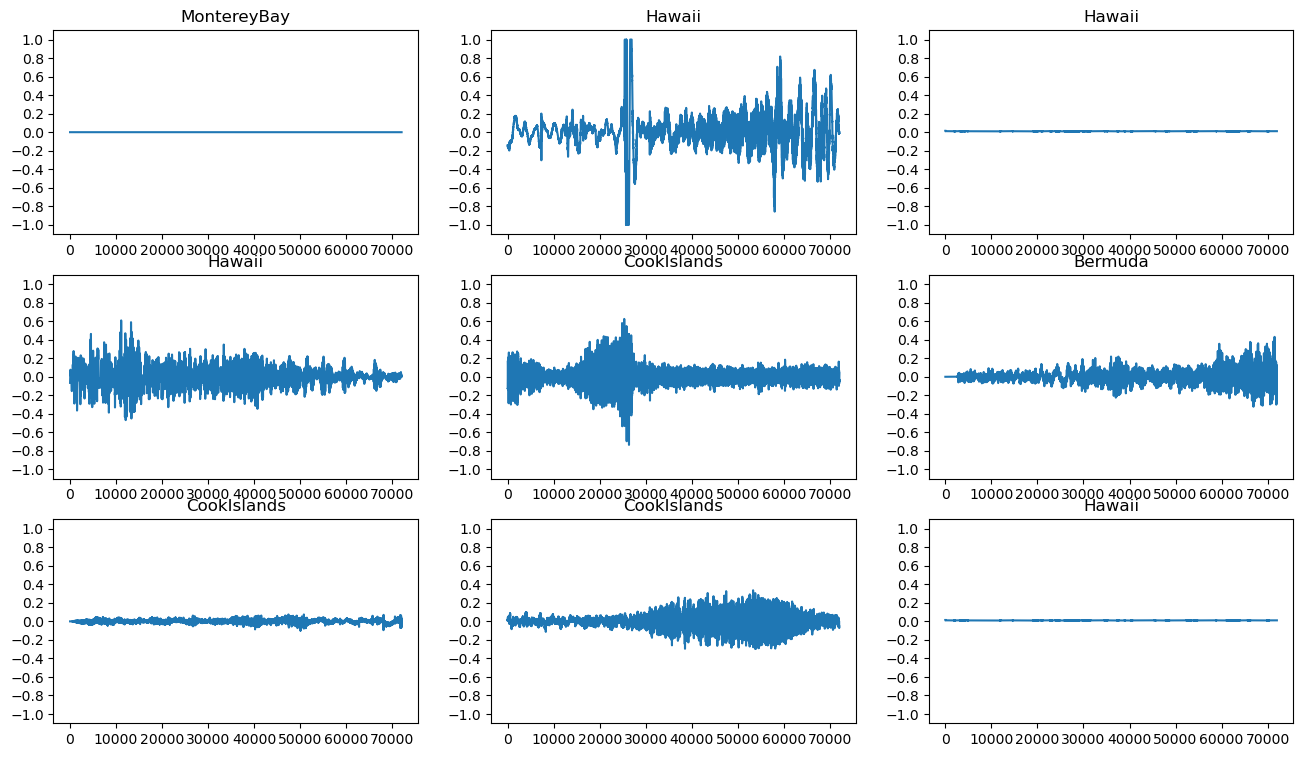

In [84]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(full_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[full_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

#### Build Spectrograms - short-time Fourier  
- The STFT requires the input tensor to have a shape of [batch_size, samples], where samples is the number of samples in the waveform.
- frame length = 512
- step = 256

In [85]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=512, frame_step=256)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [86]:
print('Waveform shape:', waveform.shape)
spectrogram = get_spectrogram(waveform)
print('Spectrogram shape:', spectrogram.shape)

Waveform shape: (72000,)
Spectrogram shape: (280, 257, 1)


#### Visualize

In [87]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

##### Spectrogram and Waveform

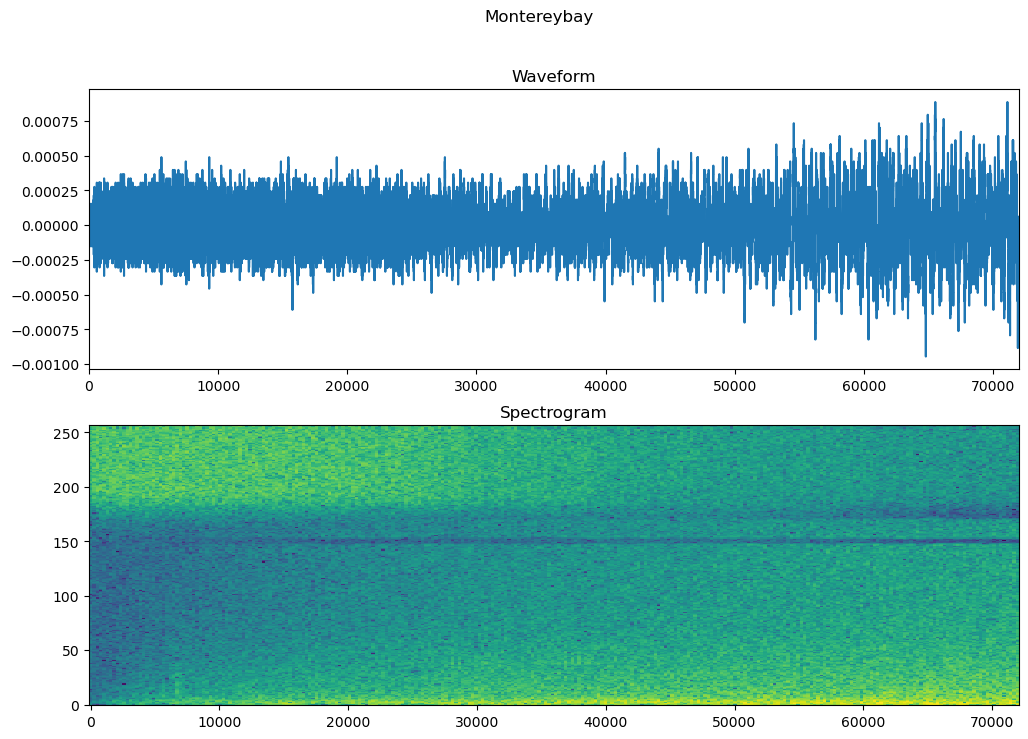

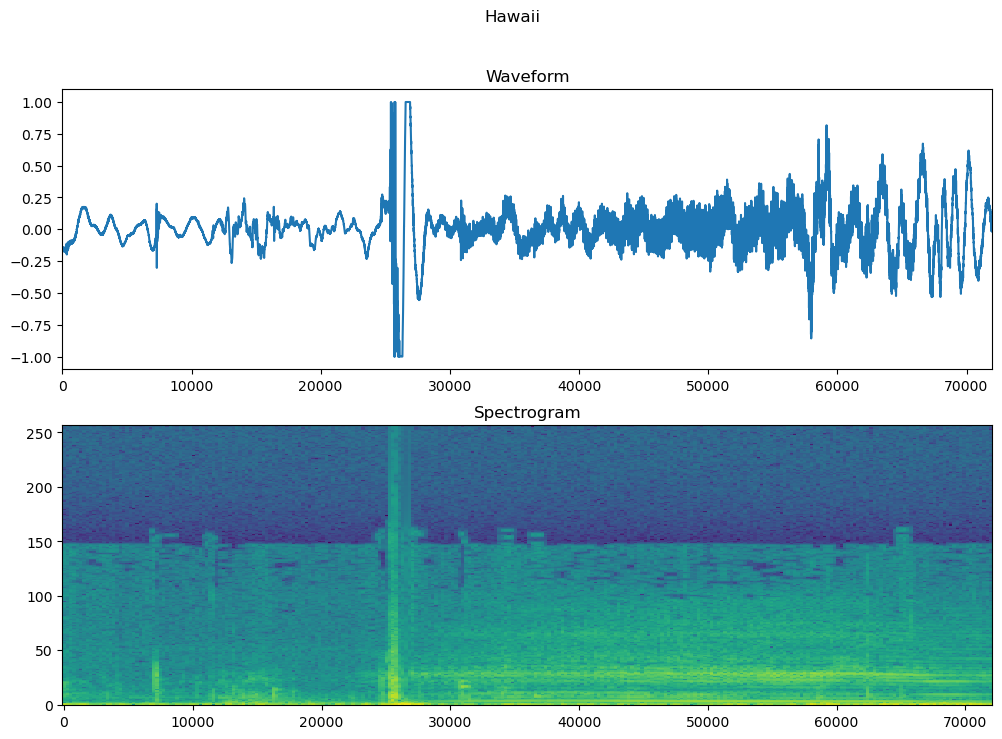

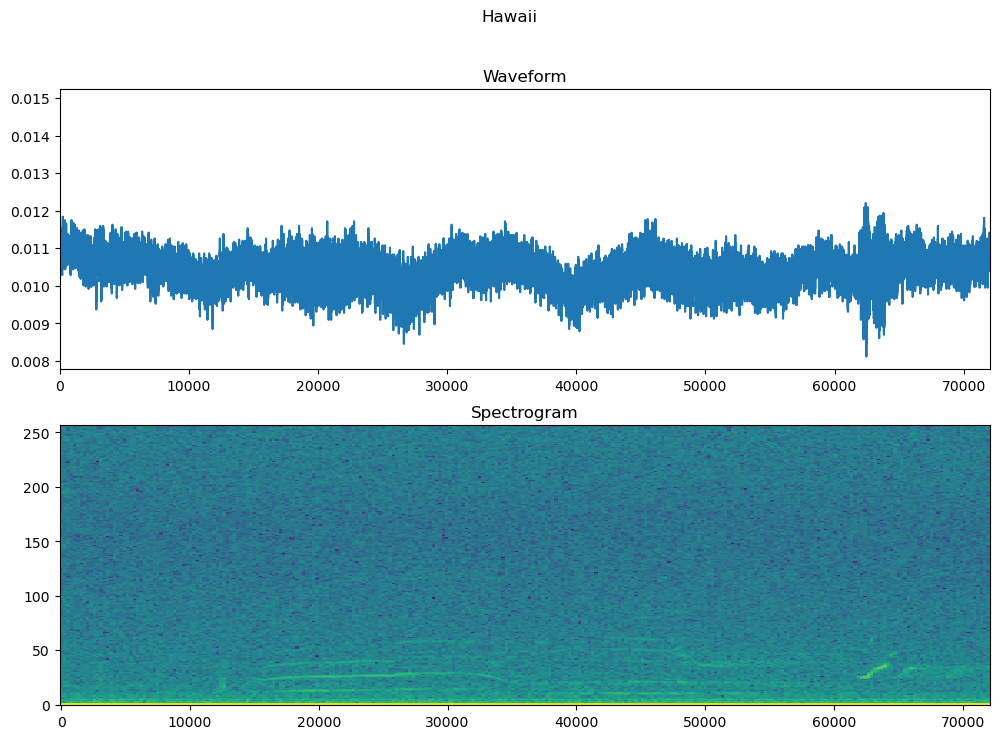

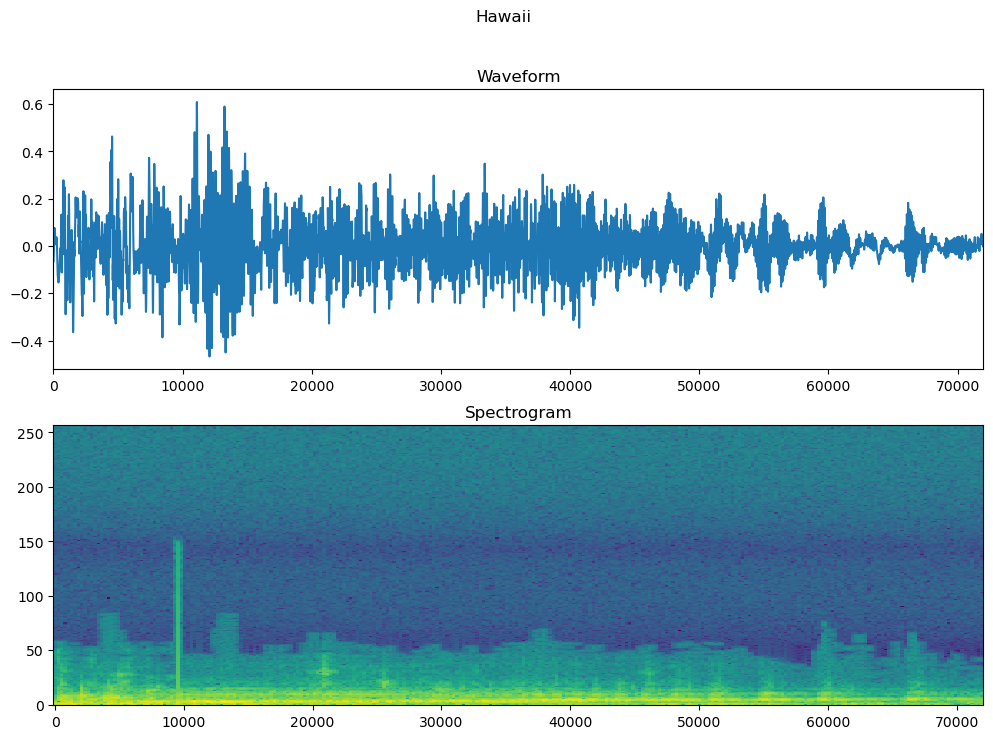

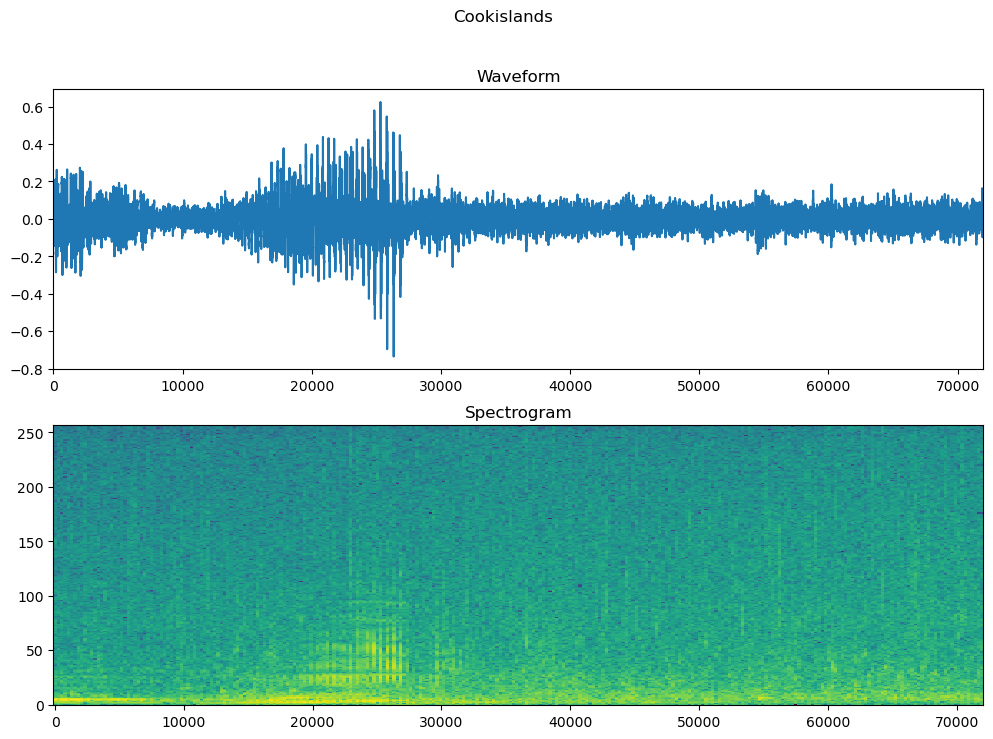

In [88]:
for i in range(5):    
    label = label_names[full_labels[i]]
    waveform = full_audio[i]
    spectrogram = get_spectrogram(waveform)
    
    fig, axes = plt.subplots(2, figsize=(12, 8))
    timescale = np.arange(waveform.shape[0])
    axes[0].plot(timescale, waveform.numpy())
    axes[0].set_title('Waveform')
    axes[0].set_xlim([0, 72000]) #maximum value of the audio signal's frequency domain

    plot_spectrogram(spectrogram.numpy(), axes[1])
    axes[1].set_title('Spectrogram')
    plt.suptitle(label.title())
    plt.show()

#### Build Spectrogram Dataset

In [89]:
def make_spec_ds(ds):  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [90]:
print(len(train_spectrogram_ds))
print(len(val_spectrogram_ds))
print(len(test_spectrogram_ds))

3
1
2


#### Visualize

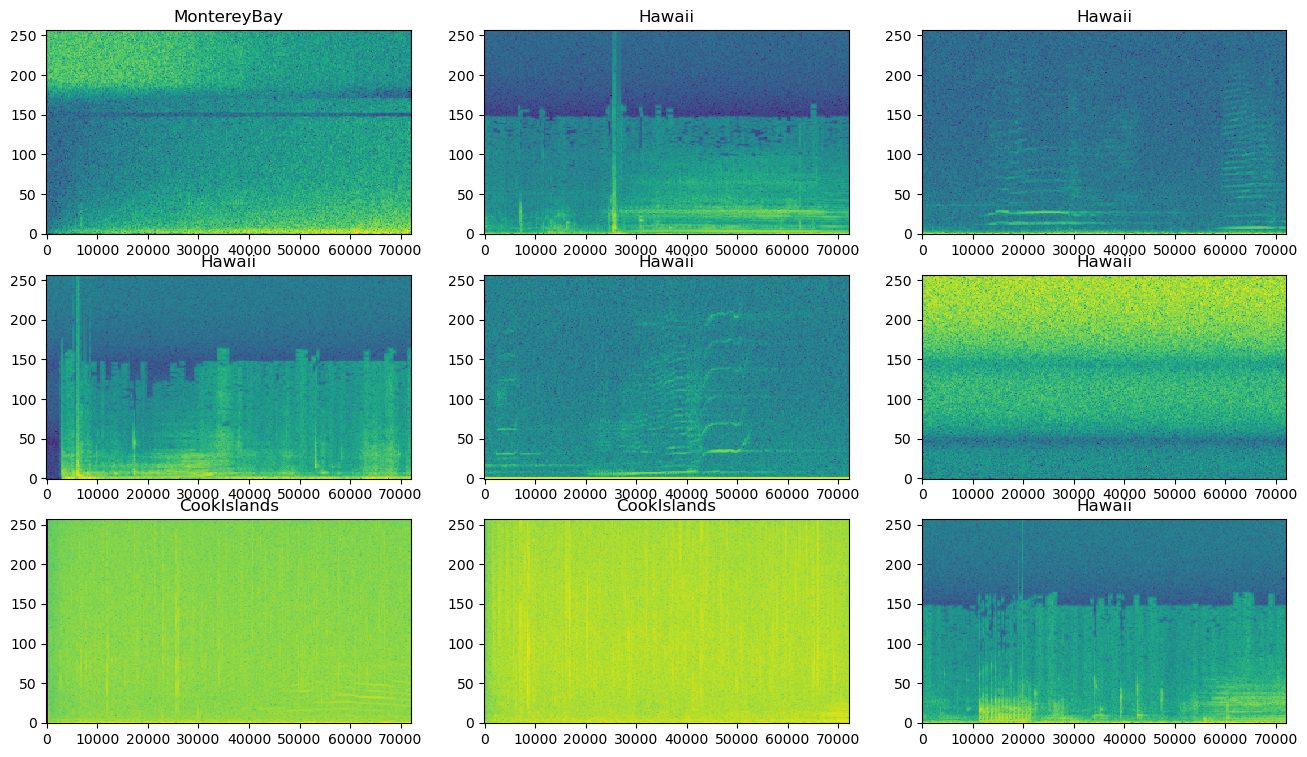

In [91]:
for full_spectrograms, full_spect_labels in train_spectrogram_ds:
    break

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(full_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[full_spect_labels[i].numpy()])

plt.show()

### Autoencoding Spectrogram data
- Image Denoising 

#### Build & Train CNN Model
- Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model

In [92]:
train_spectrogram_ds = train_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [93]:
train_spectrogram_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 280, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

- tf.keras.Sequential
    - tf.keras.layers.Resizing: to downsample the input to enable the model to train faster.
    - tf.keras.layers.Normalization: to normalize each pixel in the image based on its mean and standard deviation.
        - use 'adapt' method on training data first, to compute mean and standard deviation

In [94]:
input_shape = full_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (280, 257, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_2 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)       

#### Compile Model

In [95]:
#Compile with Adam
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

#### Fit Model

In [96]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/50
3/3 [==============================] - 6s 3s/step - loss: 1.3485 - accuracy: 0.2800 - val_loss: 1.5375 - val_accuracy: 0.2500
Epoch 2/50
3/3 [==============================] - 0s 25ms/step - loss: 1.0817 - accuracy: 0.5200 - val_loss: 2.0013 - val_accuracy: 0.2500
Epoch 3/50
3/3 [==============================] - 0s 23ms/step - loss: 1.0402 - accuracy: 0.6000 - val_loss: 2.0531 - val_accuracy: 0.3333
Epoch 4/50
3/3 [==============================] - 0s 24ms/step - loss: 0.9703 - accuracy: 0.6000 - val_loss: 1.9539 - val_accuracy: 0.3333
Epoch 4: early stopping


Text(0, 0.5, 'Accuracy [%]')

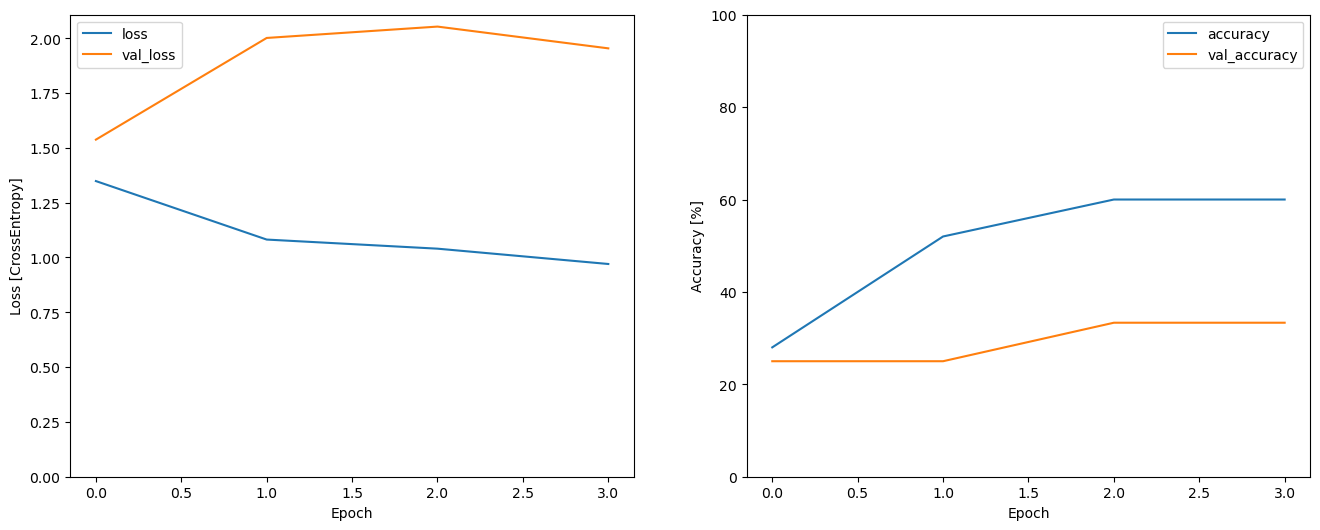

In [97]:
#Plot LOSS
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

#### Evaluation

In [98]:
#Run on test set
model.evaluate(test_spectrogram_ds, return_dict=True)

2/2 [==============================] - 5s 3s/step - loss: 2.3005 - accuracy: 0.3846


{'loss': 2.3005318641662598, 'accuracy': 0.38461539149284363}

In [99]:
# Confusion matrix
#'support' = number of instances in each class 
from sklearn.metrics import classification_report

y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in test_spectrogram_ds], axis=0)

# Classification report
print(classification_report(y_true, y_pred, target_names=label_names))

2/2 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

     Bermuda       0.00      0.00      0.00         2
 CookIslands       1.00      0.20      0.33         5
      Hawaii       0.33      1.00      0.50         4
 MontereyBay       0.00      0.00      0.00         2

    accuracy                           0.38        13
   macro avg       0.33      0.30      0.21        13
weighted avg       0.49      0.38      0.28        13



C:\Users\haley\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haley\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haley\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [100]:
# Calculate metrics on test set
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='weighted')  # weighted accounts for label imbalance
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1_score = f1_score(y_true, y_pred, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1_score:.4f}')

Test Accuracy: 0.3846
Test Precision: 0.4872
Test Recall: 0.3846
Test F1 Score: 0.2821


C:\Users\haley\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 2ms/step


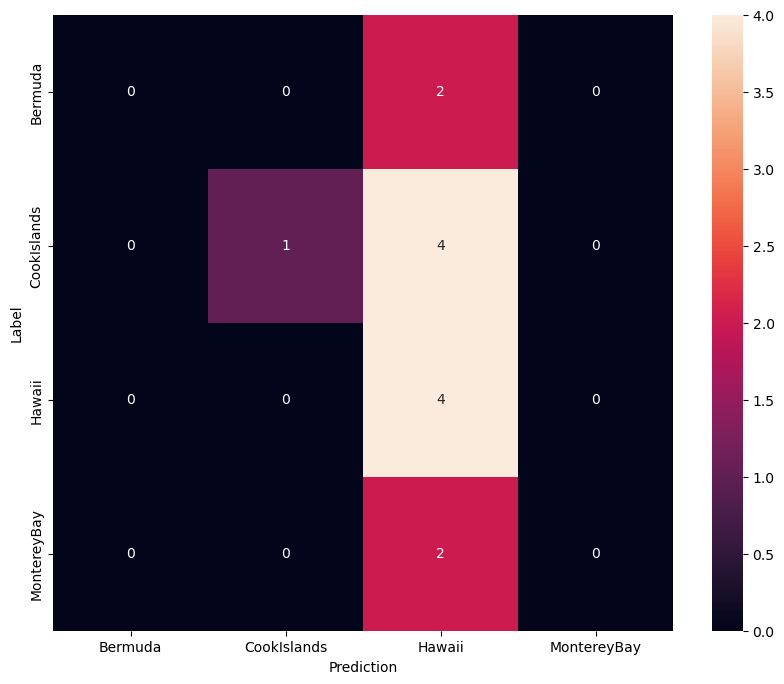

In [101]:
#confusion matrix

y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

#### Basic Autoencoder - add noise
- adjusting architecture of the encoder and decoder to match the dimensions of spectrograms - shape is (280, 257, 1) 
- autoencoder architecture uses convolutional layers to handle the 2D spectrograms. The encoder consists of two convolutional layers with stride 2 to downsample the input, followed by a dense layer to produce the latent representation. The decoder uses a dense layer to upscale the latent representation, followed by two transposed convolutional layers to upsample the feature maps back to the original dimensions, and a final convolutional layer with a sigmoid activation to produce the reconstructed spectrogram.

In [102]:
'''def make_spec_ds(ds):  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)'''

'def make_spec_ds(ds):  return ds.map(\n      map_func=lambda audio,label: (get_spectrogram(audio), label),\n      num_parallel_calls=tf.data.AUTOTUNE)\n\ntrain_spectrogram_ds = make_spec_ds(train_ds)\nval_spectrogram_ds = make_spec_ds(val_ds)\ntest_spectrogram_ds = make_spec_ds(test_ds)'

In [103]:
'''train_spectrogram_ds'''

'train_spectrogram_ds'

In [104]:
'''class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(280, 257, 1)),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(70 * 65 * 64, activation='relu'),
            layers.Reshape((70, 65, 64)),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)'''


"class Autoencoder(Model):\n    def __init__(self, latent_dim):\n        super(Autoencoder, self).__init__()\n        self.latent_dim = latent_dim\n        self.encoder = tf.keras.Sequential([\n            layers.Input(shape=(280, 257, 1)),\n            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),\n            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),\n            layers.Flatten(),\n            layers.Dense(latent_dim, activation='relu'),\n        ])\n        self.decoder = tf.keras.Sequential([\n            layers.Dense(70 * 65 * 64, activation='relu'),\n            layers.Reshape((70, 65, 64)),\n            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2),\n            layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2),\n            layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')\n        ])\n\n    def call(self, x):\n        encoded = self.encoder(x

In [105]:
'''autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(train_spectrogram_ds,
                epochs=10,
                shuffle=True,
                validation_data=test_spectrogram_ds)'''


"autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())\n\nautoencoder.fit(train_spectrogram_ds,\n                epochs=10,\n                shuffle=True,\n                validation_data=test_spectrogram_ds)"

In [106]:
'''# Get a batch of spectrograms from the test dataset
test_spectrograms, _ = next(iter(test_spectrogram_ds))
decoded_spectrograms = autoencoder.predict(test_spectrograms)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_spectrograms[i].numpy().squeeze(), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_spectrograms[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
'''

'# Get a batch of spectrograms from the test dataset\ntest_spectrograms, _ = next(iter(test_spectrogram_ds))\ndecoded_spectrograms = autoencoder.predict(test_spectrograms)\n\nn = 10\nplt.figure(figsize=(20, 4))\nfor i in range(n):\n    # Display original\n    ax = plt.subplot(2, n, i + 1)\n    plt.imshow(test_spectrograms[i].numpy().squeeze(), cmap=\'gray\')\n    plt.title("Original")\n    ax.get_xaxis().set_visible(False)\n    ax.get_yaxis().set_visible(False)\n\n    # Display reconstruction\n    ax = plt.subplot(2, n, i + 1 + n)\n    plt.imshow(decoded_spectrograms[i].squeeze(), cmap=\'gray\')\n    plt.title("Reconstructed")\n    ax.get_xaxis().set_visible(False)\n    ax.get_yaxis().set_visible(False)\nplt.show()\n'

#### Results - autoencoder is not learning a useful representation or the reconstructed spectrograms have very low intensity values. 

#### Time & Frequency Masking

In [107]:
'''def apply_freq_mask(spectrogram, label, param=10):
    masked_spectrogram = tfio.audio.freq_mask(spectrogram, param)
    return masked_spectrogram, label'''

'def apply_freq_mask(spectrogram, label, param=10):\n    masked_spectrogram = tfio.audio.freq_mask(spectrogram, param)\n    return masked_spectrogram, label'

In [108]:
'''train_masked_spectrogram_ds = train_spectrogram_ds.map(apply_freq_mask, num_parallel_calls=tf.data.AUTOTUNE)
val_masked_spectrogram_ds = val_spectrogram_ds.map(apply_freq_mask, num_parallel_calls=tf.data.AUTOTUNE)
test_masked_spectrogram_ds = test_spectrogram_ds.map(apply_freq_mask, num_parallel_calls=tf.data.AUTOTUNE)'''

'train_masked_spectrogram_ds = train_spectrogram_ds.map(apply_freq_mask, num_parallel_calls=tf.data.AUTOTUNE)\nval_masked_spectrogram_ds = val_spectrogram_ds.map(apply_freq_mask, num_parallel_calls=tf.data.AUTOTUNE)\ntest_masked_spectrogram_ds = test_spectrogram_ds.map(apply_freq_mask, num_parallel_calls=tf.data.AUTOTUNE)'

In [109]:
'''for full_spectrograms, full_spect_labels in train_masked_spectrogram_ds:
    break

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(full_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[full_spect_labels[i].numpy()])

plt.show()'''

'for full_spectrograms, full_spect_labels in train_masked_spectrogram_ds:\n    break\n\nrows = 3\ncols = 3\nn = rows*cols\nfig, axes = plt.subplots(rows, cols, figsize=(16, 9))\n\nfor i in range(n):\n    r = i // cols\n    c = i % cols\n    ax = axes[r][c]\n    plot_spectrogram(full_spectrograms[i].numpy(), ax)\n    ax.set_title(label_names[full_spect_labels[i].numpy()])\n\nplt.show()'

#### Predictions - blind test set

In [110]:
#label_names

In [111]:
#Set New Directory for Test Clips
dataset_path = 'test_clips'
data_dir = pathlib.Path(dataset_path)

#### Cook Islands

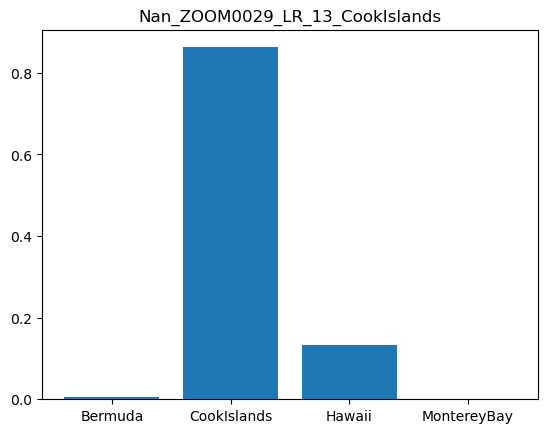

In [112]:
test = data_dir/'Nan_ZOOM0029_LR_13_CookIslands.wav'
#print(test)
test = tf.io.read_file(str(test))
#print(test)
test, sample_rate = tf.audio.decode_wav(test, desired_channels=1, desired_samples=72000,)
#print(test)
test = tf.squeeze(test, axis=-1)
#print(test)
waveform = test
test = get_spectrogram(waveform)
#print(test)
test =test[tf.newaxis,...]
#print(test)

prediction = model(test)
test_labels = label_names       
plt.bar(test_labels, tf.nn.softmax(prediction[0]))
plt.title('Nan_ZOOM0029_LR_13_CookIslands')
plt.show()

display.display(display.Audio(waveform, rate=24000))

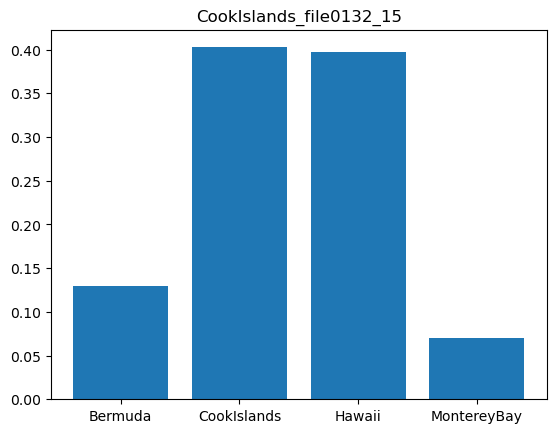

In [113]:
test = data_dir/'CookIslands_file0132_15.wav'
#print(test)
test = tf.io.read_file(str(test))
#print(test)
test, sample_rate = tf.audio.decode_wav(test, desired_channels=1, desired_samples=72000,)
#print(test)
test = tf.squeeze(test, axis=-1)
#print(test)
waveform = test
test = get_spectrogram(waveform)
#print(test)
test =test[tf.newaxis,...]
#print(test)

prediction = model(test)
test_labels = label_names       
plt.bar(test_labels, tf.nn.softmax(prediction[0]))
plt.title('CookIslands_file0132_15')
plt.show()

display.display(display.Audio(waveform, rate=24000))

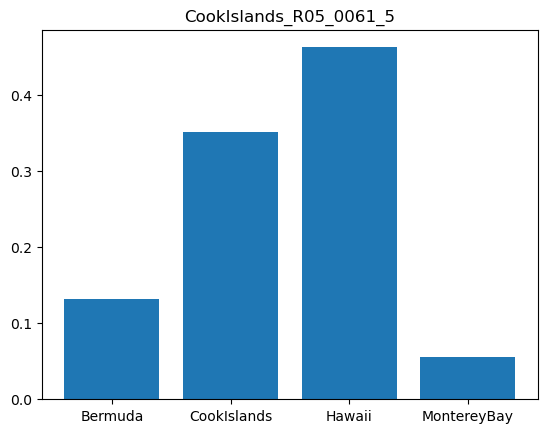

In [114]:
test = data_dir/'CookIslands_R05_0061_5.wav'
#print(test)
test = tf.io.read_file(str(test))
#print(test)
test, sample_rate = tf.audio.decode_wav(test, desired_channels=1, desired_samples=72000,)
#print(test)
test = tf.squeeze(test, axis=-1)
#print(test)
waveform = test
test = get_spectrogram(waveform)
#print(test)
test =test[tf.newaxis,...]
#print(test)

prediction = model(test)
test_labels = label_names       
plt.bar(test_labels, tf.nn.softmax(prediction[0]))
plt.title('CookIslands_R05_0061_5')
plt.show()

display.display(display.Audio(waveform, rate=24000))

#### Hawaii

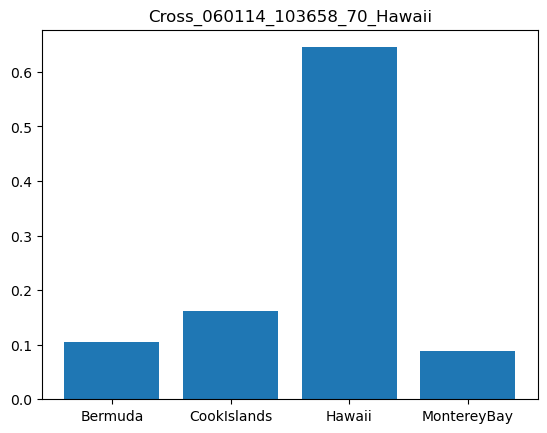

In [115]:
test = data_dir/'Cross_060114_103658_70_Hawaii.wav'
#print(test)
test = tf.io.read_file(str(test))
#print(test)
test, sample_rate = tf.audio.decode_wav(test, desired_channels=1, desired_samples=72000,)
#print(test)
test = tf.squeeze(test, axis=-1)
#print(test)
waveform = test
test = get_spectrogram(waveform)
#print(test)
test =test[tf.newaxis,...]
#print(test)

prediction = model(test)
test_labels = label_names       
plt.bar(test_labels, tf.nn.softmax(prediction[0]))
plt.title('Cross_060114_103658_70_Hawaii')
plt.show()

display.display(display.Audio(waveform, rate=24000))

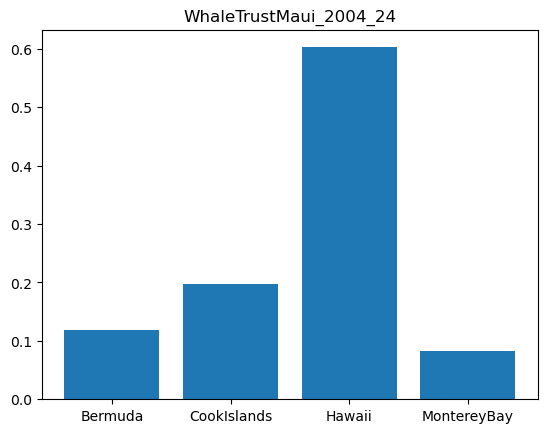

In [116]:
test = data_dir/'WhaleTrustMaui_2004_24.wav'
#print(test)
test = tf.io.read_file(str(test))
#print(test)
test, sample_rate = tf.audio.decode_wav(test, desired_channels=1, desired_samples=72000,)
#print(test)
test = tf.squeeze(test, axis=-1)
#print(test)
waveform = test
test = get_spectrogram(waveform)
#print(test)
test =test[tf.newaxis,...]
#print(test)

prediction = model(test)
test_labels = label_names       
plt.bar(test_labels, tf.nn.softmax(prediction[0]))
plt.title('WhaleTrustMaui_2004_24')
plt.show()

display.display(display.Audio(waveform, rate=24000))

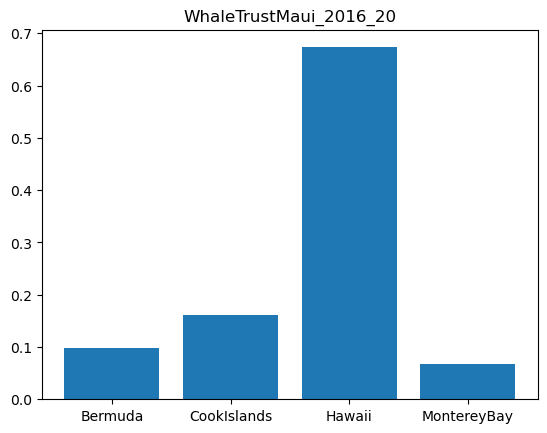

In [117]:
test = data_dir/'WhaleTrustMaui_2016_20.wav'
#print(test)
test = tf.io.read_file(str(test))
#print(test)
test, sample_rate = tf.audio.decode_wav(test, desired_channels=1, desired_samples=72000,)
#print(test)
test = tf.squeeze(test, axis=-1)
#print(test)
waveform = test
test = get_spectrogram(waveform)
#print(test)
test =test[tf.newaxis,...]
#print(test)

prediction = model(test)
test_labels = label_names       
plt.bar(test_labels, tf.nn.softmax(prediction[0]))
plt.title('WhaleTrustMaui_2016_20')
plt.show()

display.display(display.Audio(waveform, rate=24000))

#### Monterey Bay

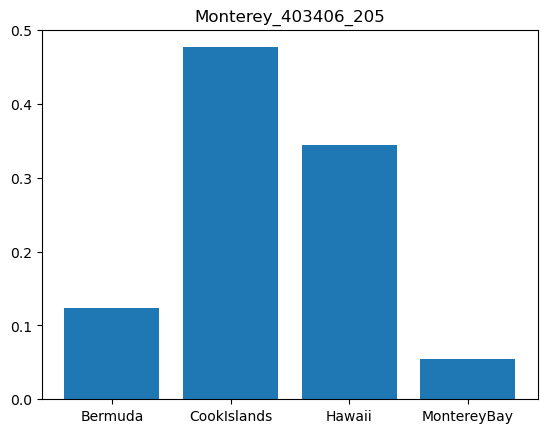

In [118]:
test = data_dir/'Monterey_403406_205.wav'
#print(test)
test = tf.io.read_file(str(test))
#print(test)
test, sample_rate = tf.audio.decode_wav(test, desired_channels=1, desired_samples=72000,)
#print(test)
test = tf.squeeze(test, axis=-1)
#print(test)
waveform = test
test = get_spectrogram(waveform)
#print(test)
test =test[tf.newaxis,...]
#print(test)

prediction = model(test)
test_labels = label_names       
plt.bar(test_labels, tf.nn.softmax(prediction[0]))
plt.title('Monterey_403406_205')
plt.show()

display.display(display.Audio(waveform, rate=24000))

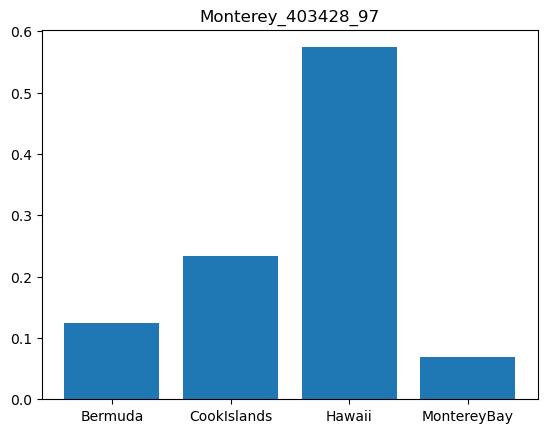

In [119]:
test = data_dir/'Monterey_403428_97.wav'
#print(test)
test = tf.io.read_file(str(test))
#print(test)
test, sample_rate = tf.audio.decode_wav(test, desired_channels=1, desired_samples=72000,)
#print(test)
test = tf.squeeze(test, axis=-1)
#print(test)
waveform = test
test = get_spectrogram(waveform)
#print(test)
test =test[tf.newaxis,...]
#print(test)

prediction = model(test)
test_labels = label_names       
plt.bar(test_labels, tf.nn.softmax(prediction[0]))
plt.title('Monterey_403428_97')
plt.show()

display.display(display.Audio(waveform, rate=24000))

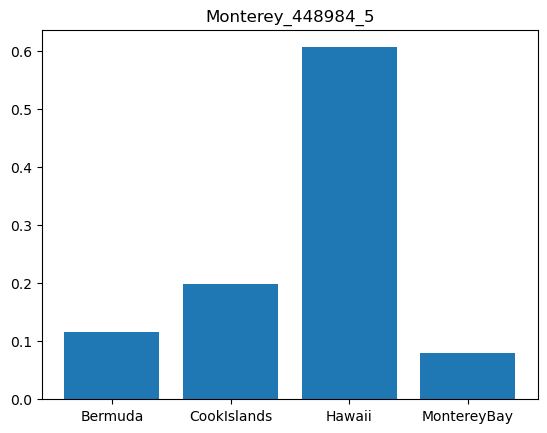

In [120]:
test = data_dir/'Monterey_448984_5.wav'
#print(test)
test = tf.io.read_file(str(test))
#print(test)
test, sample_rate = tf.audio.decode_wav(test, desired_channels=1, desired_samples=72000,)
#print(test)
test = tf.squeeze(test, axis=-1)
#print(test)
waveform = test
test = get_spectrogram(waveform)
#print(test)
test =test[tf.newaxis,...]
#print(test)

prediction = model(test)
test_labels = label_names       
plt.bar(test_labels, tf.nn.softmax(prediction[0]))
plt.title('Monterey_448984_5')
plt.show()

display.display(display.Audio(waveform, rate=24000))

#### Bermuda

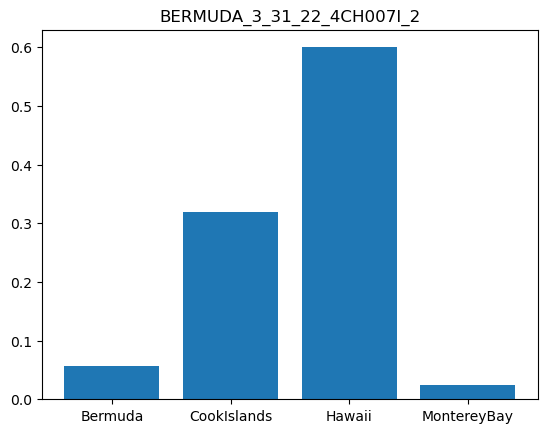

In [121]:
test = data_dir/'BERMUDA_3_31_22_4CH007I_2.wav'
#print(test)
test = tf.io.read_file(str(test))
#print(test)
test, sample_rate = tf.audio.decode_wav(test, desired_channels=1, desired_samples=72000,)
#print(test)
test = tf.squeeze(test, axis=-1)
#print(test)
waveform = test
test = get_spectrogram(waveform)
#print(test)
test =test[tf.newaxis,...]
#print(test)

prediction = model(test)
test_labels = label_names       
plt.bar(test_labels, tf.nn.softmax(prediction[0]))
plt.title('BERMUDA_3_31_22_4CH007I_2')
plt.show()

display.display(display.Audio(waveform, rate=24000))

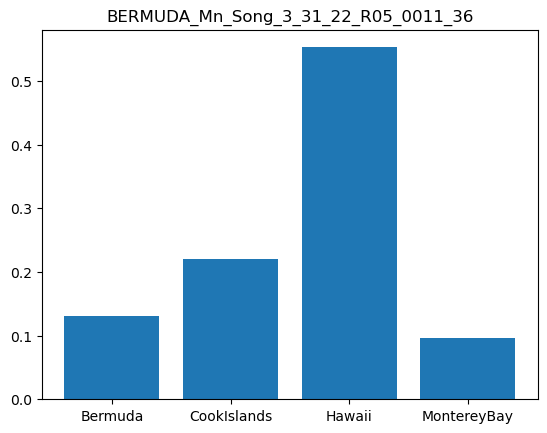

In [122]:
test = data_dir/'BERMUDA_Mn_Song_3_31_22_R05_0011_36.wav'
#print(test)
test = tf.io.read_file(str(test))
#print(test)
test, sample_rate = tf.audio.decode_wav(test, desired_channels=1, desired_samples=72000,)
#print(test)
test = tf.squeeze(test, axis=-1)
#print(test)
waveform = test
test = get_spectrogram(waveform)
#print(test)
test =test[tf.newaxis,...]
#print(test)

prediction = model(test)
test_labels = label_names       
plt.bar(test_labels, tf.nn.softmax(prediction[0]))
plt.title('BERMUDA_Mn_Song_3_31_22_R05_0011_36')
plt.show()

display.display(display.Audio(waveform, rate=24000))

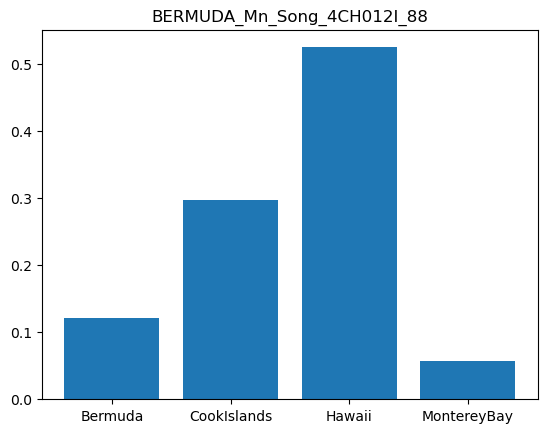

In [123]:
test = data_dir/'BERMUDA_Mn_Song_4CH012I_88.wav'
#print(test)
test = tf.io.read_file(str(test))
#print(test)
test, sample_rate = tf.audio.decode_wav(test, desired_channels=1, desired_samples=72000,)
#print(test)
test = tf.squeeze(test, axis=-1)
#print(test)
waveform = test
test = get_spectrogram(waveform)
#print(test)
test =test[tf.newaxis,...]
#print(test)

prediction = model(test)
test_labels = label_names       
plt.bar(test_labels, tf.nn.softmax(prediction[0]))
plt.title('BERMUDA_Mn_Song_4CH012I_88')
plt.show()

display.display(display.Audio(waveform, rate=24000))

#### Export Model

## TO DO
- optimize **images** - fade in/out, reduce noise
- optimize **spectrograms**
    - stft vs Speech Recognition 512/512/512 split
    - mel-spectrogram vs regular
- optimize **model**
    - try different types/different layers
    - softmax vs relu
    - number of epochs
    - what type of loss metric? https://www.tensorflow.org/api_docs/python/tf/keras/losses
    - callbacks?
- **Rate** - make sure 30 sec or less are covered in audio data - rate = 1,000 / 30,000.
    - **How do i choose correct rate?**